# Predicting flight delays

Celem projektu jest przeanalizowanie danych z biura U.S. Department of Transportation’s (DOT) Bureau of Transportation Statistics które śledzi terminowość lotów krajowych obsługiwanych przez dużych przewoźników lotniczych. Na podstawie przeanalizowanych danych chcęmy stworzyć model odpowiadający na pytanie: Którą linią lotniczą powinieneś polecieć, aby uniknąć znacznych opóźnień? Predykcja opóźnień lotów.

Zbiór daych zawiera podsumowanie informacji o liczbie lotów na czas, opóź- nionych, odwołanych i przekierowanych. Informacja dotyczy roku 2015. Zbiór daych będzie pobrany ze strony: https://www.kaggle.com/usdot/flight-delays?fbclid=IwAR35RJkExG8_KySniI_W9RCrHTdkreTkNSuXfoiRBvpDhxuqT0ol4L-gjCk#flights.csv

Zbiór danych zawarty jest w trzech plikach csv: airlines.csv, airports.csv oraz flights.csv. Macierz zawarta w pliku airlines.csv zawiera jedynie dwie kolumny -- w pierwszej z nich przedstawiono identyfiaktor linii lotniczej, a w drugiej pełną nazwę tej linii. W pliku airports.csv przedstawiono informacje o pojawiających się w danych lotniskach -- mamy tu już do czynienia z siedmioma kolumnami, opisującymi podstawowe dane o portach lotniczych. Naszym głównym przedmiotem analizy będzie plik flights.csv, który w 31 kolumnach gromadzi dane o lotach.

In [1]:
import datetime, warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches


### Wczytanie danych

In [2]:
flights=pd.read_csv("flights.csv")

/home/knigawkl/Desktop/med/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
flights.shape

(5819079, 31)

### Obcięcie danych 

Z powodu ilości danych utrudniającej szybką pracę na własnych maszynach roboczych, zdecydowano się na zmniejszenie objętości danych. W tym celu zdecydowano się na wzięcie z każdego miesiąca pierwszych 200000 rekordów.

In [4]:
flights=flights.groupby('MONTH').head(200000).reset_index(drop=True)
flights['MONTH'].value_counts()
flights.to_csv("new_flights.csv",encoding='utf-8',index=False)

## Wczytanie nowego pliku csv

In [5]:
flights=pd.read_csv("new_flights.csv")
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
flights.shape

(2400000, 31)

Jak widać, ponad dwukrotnie zmniejszono liczbę rekorów w zbiorze.

Zobaczmy jaka część z "przyciętych" danych dotyczy lotów anulowanych.

In [7]:
flights["CANCELLED"].value_counts()

0    2362963
1      37037
Name: CANCELLED, dtype: int64

In [8]:
flights.tail()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
2399995,2015,12,14,1,F9,927,N927FR,TTN,UST,630,...,843.0,-27.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2399996,2015,12,14,1,F9,1310,N928FR,ORD,MIA,630,...,1024.0,-31.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2399997,2015,12,14,1,HA,114,N480HA,HNL,OGG,630,...,710.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2399998,2015,12,14,1,MQ,3061,N941MQ,LCH,DFW,630,...,745.0,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2399999,2015,12,14,1,MQ,3198,N604MQ,FAR,DFW,630,...,856.0,-37.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Opis column 
YEAR -- Year of the Flight Trip

MONTH -- Month of the Flight Trip

DAY -- Day of the Flight Trip

DAY_OF_WEEK -- Day of week of the Flight Trip

AIRLINE -- Airline Identifier

FLIGHT_NUMBER -- Flight Identifier

TAIL_NUMBER -- Aircraft Identifier

ORIGIN_AIRPORT -- Starting Airport

DESTINATION_AIRPORT -- Destination Airport

SCHEDULED_DEPARTURE -- Planned Departure Time

DEPARTURE_TIME -- WHEEL_OFF - TAXI_OUT

DEPARTURE_DELAY -- Total Delay on Departure

TAXI_OUT -- The time duration elapsed between departure from the origin airport gate and wheels off

WHEELS_OFF -- The time point that the aircraft's wheels leave the ground

SCHEDULED_TIME -- Planned time amount needed for the flight trip

ELAPSED_TIME -- AIR_TIME+TAXI_IN+TAXI_OUT

AIR_TIME -- The time duration between wheels_off and wheels_on time

DISTANCE -- Distance between two airports

WHEELS_ON -- The time point that the aircraft's wheels touch on the ground

TAXI_IN -- The time duration elapsed between wheels-on and gate arrival at the destination airport

SCHEDULED_ARRIVAL -- Planned arrival time

ARRIVAL_TIME -- WHEELS_ON+TAXI_IN

ARRIVAL_DELAY -- ARRIVAL_TIME-SCHEDULED_ARRIVAL

DIVERTED -- Aircraft landed on airport that out of schedule

CANCELLED -- Flight Cancelled (1 = cancelled)

CANCELLATION_REASON -- Reason for Cancellation of flight: A - Airline/Carrier; B - Weather; C - National Air System; D - Security

AIR_SYSTEM_DELAY Delay -- caused by air system

SECURITY_DELAY Delay -- caused by security

AIRLINE_DELAY Delay -- caused by the airline

LATE_AIRCRAFT_DELAY -- Delay caused by aircraft

WEATHER_DELAY Delay -- caused by weather


Poniżej znajduje się pierwszy przegląd wszystkich atrybutów:

In [9]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 31 columns):
YEAR                   int64
MONTH                  int64
DAY                    int64
DAY_OF_WEEK            int64
AIRLINE                object
FLIGHT_NUMBER          int64
TAIL_NUMBER            object
ORIGIN_AIRPORT         object
DESTINATION_AIRPORT    object
SCHEDULED_DEPARTURE    int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE               int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL      int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED               int64
CANCELLED              int64
CANCELLATION_REASON    object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT

Widoczny jest problem z atrybutami które repezentują czas. Czas w tych atrybutach jest zaprezentowany jako float64 oraz wygląda to przykładowo jako 843.0. Istnieje potrzeba przekonwertowania tego na datę i godzinę.

In [10]:
# converting input time value to datetime.
def conv_time(time_val):
    if pd.isnull(time_val):
        return np.nan
    else:
            # replace 24:00 o'clock with 00:00 o'clock:
        if time_val == 2400: time_val = 0
            # creating a 4 digit value out of input value:
        time_val = "{0:04d}".format(int(time_val))
            # creating a time datatype out of input value: 
        time_formatted = datetime.time(int(time_val[0:2]), int(time_val[2:4]))
    return time_formatted

In [11]:
flights['ARRIVAL_TIME'] = flights['ARRIVAL_TIME'].apply(conv_time)
flights['DEPARTURE_TIME'] = flights['DEPARTURE_TIME'].apply(conv_time)
flights['SCHEDULED_DEPARTURE'] = flights['SCHEDULED_DEPARTURE'].apply(conv_time)
flights['WHEELS_OFF'] = flights['WHEELS_OFF'].apply(conv_time)
flights['WHEELS_ON'] = flights['WHEELS_ON'].apply(conv_time)
flights['SCHEDULED_ARRIVAL'] = flights['SCHEDULED_ARRIVAL'].apply(conv_time)

Teraz dane mają przyjaźniejszy format.

In [12]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,00:05:00,...,04:08:00,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,00:10:00,...,07:41:00,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,00:20:00,...,08:11:00,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,00:20:00,...,07:56:00,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,00:25:00,...,02:59:00,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Czyszczenie danych 

Po przekonwertowaniu niezbędnych wartości czasu na typ danych DateTime, trzeba sprawdzić dane zgodnie z ich integralnością. Wartości zerowe lub brakujące dane trzeba obsłużyć. Niżej jest zaprezentowana suma brakujących danych dla poszczególnych cech.

In [13]:
flights.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER               5397
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           35587
DEPARTURE_DELAY          35587
TAXI_OUT                 36676
WHEELS_OFF               36676
SCHEDULED_TIME               4
ELAPSED_TIME             42996
AIR_TIME                 42996
DISTANCE                     0
WHEELS_ON                38059
TAXI_IN                  38059
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             38059
ARRIVAL_DELAY            42996
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    2362963
AIR_SYSTEM_DELAY       1963672
SECURITY_DELAY         1963672
AIRLINE_DELAY          1963672
LATE_AIRCRAFT_DELAY    1963672
WEATHER_DELAY          1963672
dtype: int64

Analiza zerowa pokazuje które atrybuty posiadają najwęcej zerowych wartości:

* CANCELLATION_REASON
* AIR_SYSTEM_DELAY
* SECURITY_DELAY
* AIRLINE_DELAY
* LATE_AIRCRAFT_DELAY
* WEATHER_DELAY

Można więc przekształcić dane NAN na wartość „0.0”, ponieważ dane te nie miały wpływu na lot.

In [14]:
flights['AIRLINE_DELAY'] = flights['AIRLINE_DELAY'].fillna(0)
flights['AIR_SYSTEM_DELAY'] = flights['AIR_SYSTEM_DELAY'].fillna(0)
flights['SECURITY_DELAY'] = flights['SECURITY_DELAY'].fillna(0)
flights['LATE_AIRCRAFT_DELAY'] = flights['LATE_AIRCRAFT_DELAY'].fillna(0)
flights['WEATHER_DELAY'] = flights['WEATHER_DELAY'].fillna(0)

In [15]:
flights.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER               5397
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           35587
DEPARTURE_DELAY          35587
TAXI_OUT                 36676
WHEELS_OFF               36676
SCHEDULED_TIME               4
ELAPSED_TIME             42996
AIR_TIME                 42996
DISTANCE                     0
WHEELS_ON                38059
TAXI_IN                  38059
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             38059
ARRIVAL_DELAY            42996
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    2362963
AIR_SYSTEM_DELAY             0
SECURITY_DELAY               0
AIRLINE_DELAY                0
LATE_AIRCRAFT_DELAY          0
WEATHER_DELAY                0
dtype: int64

Wartości zerowe znacznie spadły. Zostało tylko kilka atrybutów. Szczególnie dużo zer jest jednak dla cechi CANCELLATION_REASON, prawie cała kolumna jest zerowa. Powód odwołania lotów dzieli się na następujące zdarzenia:
* A - Linia lotnicza / przewoźnik
* B - Pogoda
* C - National Air System
* D - Bezpieczeństwo

Poniżej są zaprezentowane liczności danych powodów odwolania lotu:

In [16]:
flights['CANCELLATION_REASON'].value_counts()

B    19083
A    10893
C     7047
D       14
Name: CANCELLATION_REASON, dtype: int64

Sprawdźmy, jaka część lotów została z jakiegokolwiek powodu anulowana


In [17]:
flights['CANCELLATION_REASON'].value_counts().sum() / flights.shape[0] * 100

1.5432083333333335

Wynik w okolicach 1.5% wydaje się być bardzo prawdopodobny.

In [18]:
flights['CANCELLATION_REASON'].tail()

2399995    NaN
2399996    NaN
2399997    NaN
2399998    NaN
2399999    NaN
Name: CANCELLATION_REASON, dtype: object

Jak widać głównym powodem anulowania lotu jest pogoda B. Powszechnie wiadomo, że pogoda jest często przyczyną opóźnień i odwołań. W przypadku tego atrybutu patrzymy na pogodę jako przyczynę anulowania, a nie opóźnienia. Teraz pojawia się następujące pytanie: Jeśli chcemy przewidzieć czasy opóźnień lotów, czy konieczne jest uwzględnienie przyczyn odwołania lotu w naszych obliczeniach? Czy nie chcemy skupiać się wyłącznie na lotach nieodwołanych, na lotach z wylotem i (późnym) czasem przylotu? Odpowiedź jest następująca: nie chcemy stracić danych do naszych prognoz. W tym przypadku każda informacja jest ważna. Na przykład przyczyna anulowania „Pogoda” dla odwołanego lotu. Sam lot się nie odbył, to prawda, ale co z konsekwencjami odwołanych lotów? Wszyscy pasażerowie muszą dotrzeć do miejsca docelowego, dlatego zostaną zarezerwowani na inny lot, albo anulowany lot rozpocznie się z opóźneniem i prawdopodobnie zablokuje miejsce na  inne loty. To wszystko prowadzi do efektu domina.

Dlatego, że część modeli nie działa całkiem dobrze z wartościami kategorycznymi. Muszą zostać przekonwertowane na wartości liczbowe, aby użyć modelu predykcyjnego. Encoding powódów odwołania lotów został został zrobiony w następujący sposób:

NaN = 0 A = 1 B = 2 C = 3 D = 4

In [19]:
flights.loc[flights['CANCELLATION_REASON'] == 'A', 'CANCELLATION_REASON'] = 1
flights.loc[flights['CANCELLATION_REASON'] == 'B', 'CANCELLATION_REASON'] = 2
flights.loc[flights['CANCELLATION_REASON'] == 'C', 'CANCELLATION_REASON'] = 3
flights.loc[flights['CANCELLATION_REASON'] == 'D', 'CANCELLATION_REASON'] = 4
flights['CANCELLATION_REASON'] = flights['CANCELLATION_REASON'].fillna(0)

In [20]:
flights.isnull().sum()

YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE                    0
FLIGHT_NUMBER              0
TAIL_NUMBER             5397
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME         35587
DEPARTURE_DELAY        35587
TAXI_OUT               36676
WHEELS_OFF             36676
SCHEDULED_TIME             4
ELAPSED_TIME           42996
AIR_TIME               42996
DISTANCE                   0
WHEELS_ON              38059
TAXI_IN                38059
SCHEDULED_ARRIVAL          0
ARRIVAL_TIME           38059
ARRIVAL_DELAY          42996
DIVERTED                   0
CANCELLED                  0
CANCELLATION_REASON        0
AIR_SYSTEM_DELAY           0
SECURITY_DELAY             0
AIRLINE_DELAY              0
LATE_AIRCRAFT_DELAY        0
WEATHER_DELAY              0
dtype: int64

In [21]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,00:05:00,...,04:08:00,-22.0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,00:10:00,...,07:41:00,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,00:20:00,...,08:11:00,5.0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,00:20:00,...,07:56:00,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,00:25:00,...,02:59:00,-21.0,0,0,0,0.0,0.0,0.0,0.0,0.0


In [22]:
prev_row_count = flights.shape[0]

Sprawdźmy, ilu przedstawicieli danych klas kolumny Cancellation Reason znajduje się w zbiorze przed usunięciem rekordów zawierających brakujące dane

In [23]:
flights.groupby('CANCELLATION_REASON').size()

CANCELLATION_REASON
0    2362963
1      10893
2      19083
3       7047
4         14
dtype: int64

Poniższa instrukcja usuwa rekordy, w których znajduje się co najmniej jedna brakująca wartość. 

In [24]:
flights = flights.dropna()

In [25]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,00:05:00,...,04:08:00,-22.0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,00:10:00,...,07:41:00,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,00:20:00,...,08:11:00,5.0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,00:20:00,...,07:56:00,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,00:25:00,...,02:59:00,-21.0,0,0,0,0.0,0.0,0.0,0.0,0.0


In [26]:
flights

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,00:05:00,...,04:08:00,-22.0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,00:10:00,...,07:41:00,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,00:20:00,...,08:11:00,5.0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,00:20:00,...,07:56:00,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,00:25:00,...,02:59:00,-21.0,0,0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,2015,12,14,1,F9,927,N927FR,TTN,UST,06:30:00,...,08:43:00,-27.0,0,0,0,0.0,0.0,0.0,0.0,0.0
2399996,2015,12,14,1,F9,1310,N928FR,ORD,MIA,06:30:00,...,10:24:00,-31.0,0,0,0,0.0,0.0,0.0,0.0,0.0
2399997,2015,12,14,1,HA,114,N480HA,HNL,OGG,06:30:00,...,07:10:00,1.0,0,0,0,0.0,0.0,0.0,0.0,0.0
2399998,2015,12,14,1,MQ,3061,N941MQ,LCH,DFW,06:30:00,...,07:45:00,-7.0,0,0,0,0.0,0.0,0.0,0.0,0.0


In [27]:
row_count = flights.shape[0]
removed_part = (prev_row_count - row_count) / prev_row_count * 100
print(f'Usunięto {removed_part} procent wszystkich rekordów')

Usunięto 1.7915 procent wszystkich rekordów


In [28]:
flights.groupby('CANCELLATION_REASON').size()

CANCELLATION_REASON
0    2357004
dtype: int64

Można zaobserwować, że po usunięciu wszystkich rekordów zawierających brakujące dane, pomimo iż usunięto zaledwie niecałe 2% zbioru, nie posiadamy już danych na temat powodów anulowania lotów. Na ten moment wydaje się, iż zrezygnowanie z analizy lotów anulowanych może być całkiem niezłym pomysłem. Wzięcie pod uwagę tych dość rzadkich danych byłoby trudne, i raczej nieznacznie wpłynęłoby na nasz model regresyjny.

In [38]:
flights.isnull().sum()

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
CANCELLATION_REASON    0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
AIRLINE                0
DELAYED                0
dtype: int64

## Zakresy wartości 
Poniżej przedstawiono zwięzłe przedstawienie najbardziej podstawowych miar statystycznych zebranych dla poszczególnych kolumn.

In [30]:
flights.loc[:,'AIRLINE':'WEATHER_DELAY'].describe()

,FLIGHT_NUMBER,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,2.357004e+06,2.357004e+06,2.357004e+06,2.357004e+06,2.357004e+06,2.357004e+06,2.357004e+06,2.357004e+06,2.357004e+06,2357004.0,2357004.0,2357004.0,2.357004e+06,2.357004e+06,2.357004e+06,2.357004e+06,2.357004e+06
mean,2.160400e+03,8.923538e+00,1.607117e+01,1.416852e+02,1.368661e+02,1.133559e+02,8.224464e+02,7.438951e+00,4.104376e+00,0.0,0.0,0.0,2.504739e+00,1.459565e-02,3.473835e+00,4.199098e+00,5.062558e-01
std,1.754539e+03,3.584455e+01,8.800830e+00,7.515857e+01,7.411325e+01,7.216350e+01,6.071873e+02,5.631672e+00,3.830434e+01,0.0,0.0,0.0,1.288016e+01,1.002206e+00,2.167526e+01,1.990213e+01,8.536964e+00
min,1.000000e+00,-6.800000e+01,1.000000e+00,1.800000e+01,1.400000e+01,7.000000e+00,3.100000e+01,1.000000e+00,-8.700000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.260000e+02,-5.000000e+00,1.100000e+01,8.500000e+01,8.200000e+01,6.000000e+01,3.730000e+02,4.000000e+00,-1.300000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.675000e+03,-2.000000e+00,1.400000e+01,1.230000e+02,1.180000e+02,9.400000e+01,6.470000e+02,6.000000e+00,-5.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.204000e+03,7.000000e+00,1.900000e+01,1.730000e+02,1.680000e+02,1.440000e+02,1.065000e+03,9.000000e+00,8.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.320000e+03,1.878000e+03,1.800000e+02,7.180000e+02,7.660000e+02,6.900000e+02,4.983000e+03,1.970000e+02,1.898000e+03,0.0,0.0,0.0,1.049000e+03,5.730000e+02,1.878000e+03,1.331000e+03,1.118000e+03


## Dodanie lotnisk do analizy

Następnym krokiem analizy jest dodanie lokalizacji do danych. Chcemy uwzględnić lotniska i spróbować dowiedzieć się, czy ma to wpływ na opóźnienie. Aby to zrobić dodamy dane z innego pliku który zawiera wszystkie lotniska.


In [31]:
airlines = pd.read_csv('airlines.csv')
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [32]:
flights = flights.merge(airlines, left_on='AIRLINE', right_on='IATA_CODE', how='inner')

In [33]:
flights = flights.drop(['AIRLINE_x','IATA_CODE'], axis=1)
flights = flights.rename(columns={"AIRLINE_y":"AIRLINE"})

In [39]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,DELAYED
0,2015,1,1,4,98,N407AS,ANC,SEA,00:05:00,23:54:00,...,0,0,0,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,False
1,2015,1,1,4,135,N527AS,SEA,ANC,00:25:00,00:24:00,...,0,0,0,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,False
2,2015,1,1,4,108,N309AS,ANC,SEA,00:45:00,00:41:00,...,0,0,0,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,False
3,2015,1,1,4,122,N413AS,ANC,PDX,00:50:00,00:46:00,...,0,0,0,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,False
4,2015,1,1,4,130,N457AS,FAI,SEA,01:15:00,01:07:00,...,0,0,0,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,False


### Analiza lotów w zależności od firmy

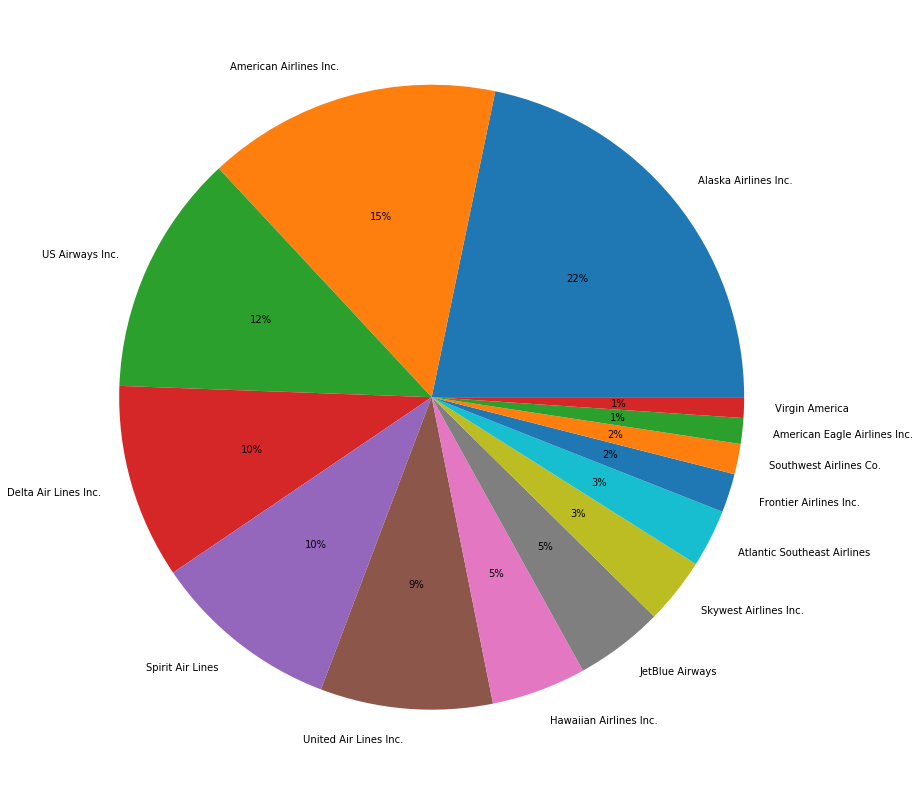

In [34]:
fig_dim = (14,18)
f, ax = plt.subplots(figsize=fig_dim)
quality=flights["AIRLINE"].unique()
size=flights["AIRLINE"].value_counts()

plt.pie(size,labels=quality,autopct='%1.0f%%')
plt.show()

### Analiza opóźnień w zależnosci od firmy

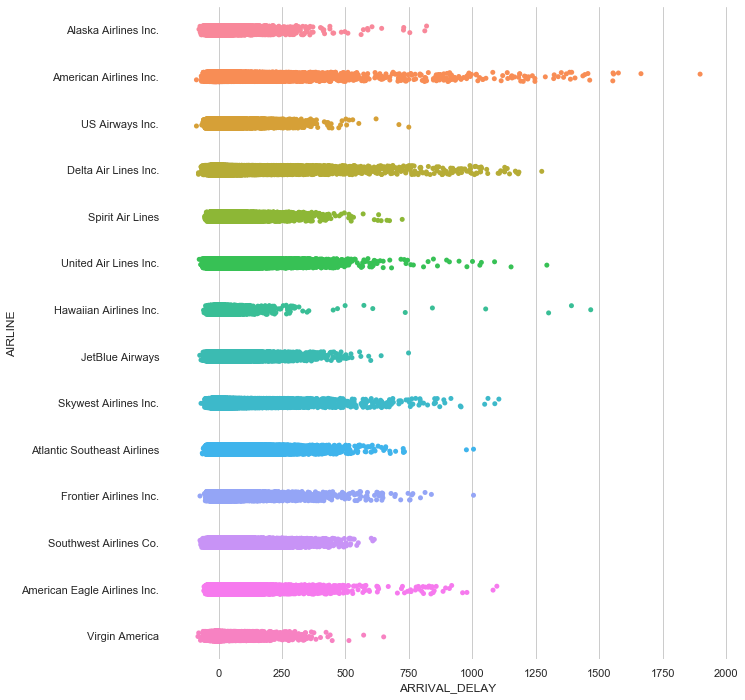

In [35]:
sns.set(style="whitegrid")

fig_dim = (10,12)
f, ax = plt.subplots(figsize=fig_dim)
sns.despine(bottom=True, left=True)
#parametr dodge:
#When using hue nesting, setting this to True will separate the strips for different hue levels along the categorical axis. 
#Otherwise, the points for each level will be plotted on top of each other.
#parametr jitter 
'''Amount of jitter (only along the categorical axis) to apply. 
This can be useful when you have many points and they overlap, so that it is easier to see the distribution.
You can specify the amount of jitter 
(half the width of the uniform random variable support), or just use True for a good default.'''
sns.stripplot(x="ARRIVAL_DELAY", y="AIRLINE", data=flights, dodge=True, jitter=True)
plt.show()

Powyższa dystrybucja pokazuje linie lotnicze w porównaniu do ich ARRIVAL_DELAY. To wyraźnie pokazuje, że American Airlines ma szeroki zakres opóźnień. 

## Korelacja cech

Głównym celem jest zidentyfikowanie cech wpływających na ARRIVAL_DELAY w pozytywny lub negatywny sposób.

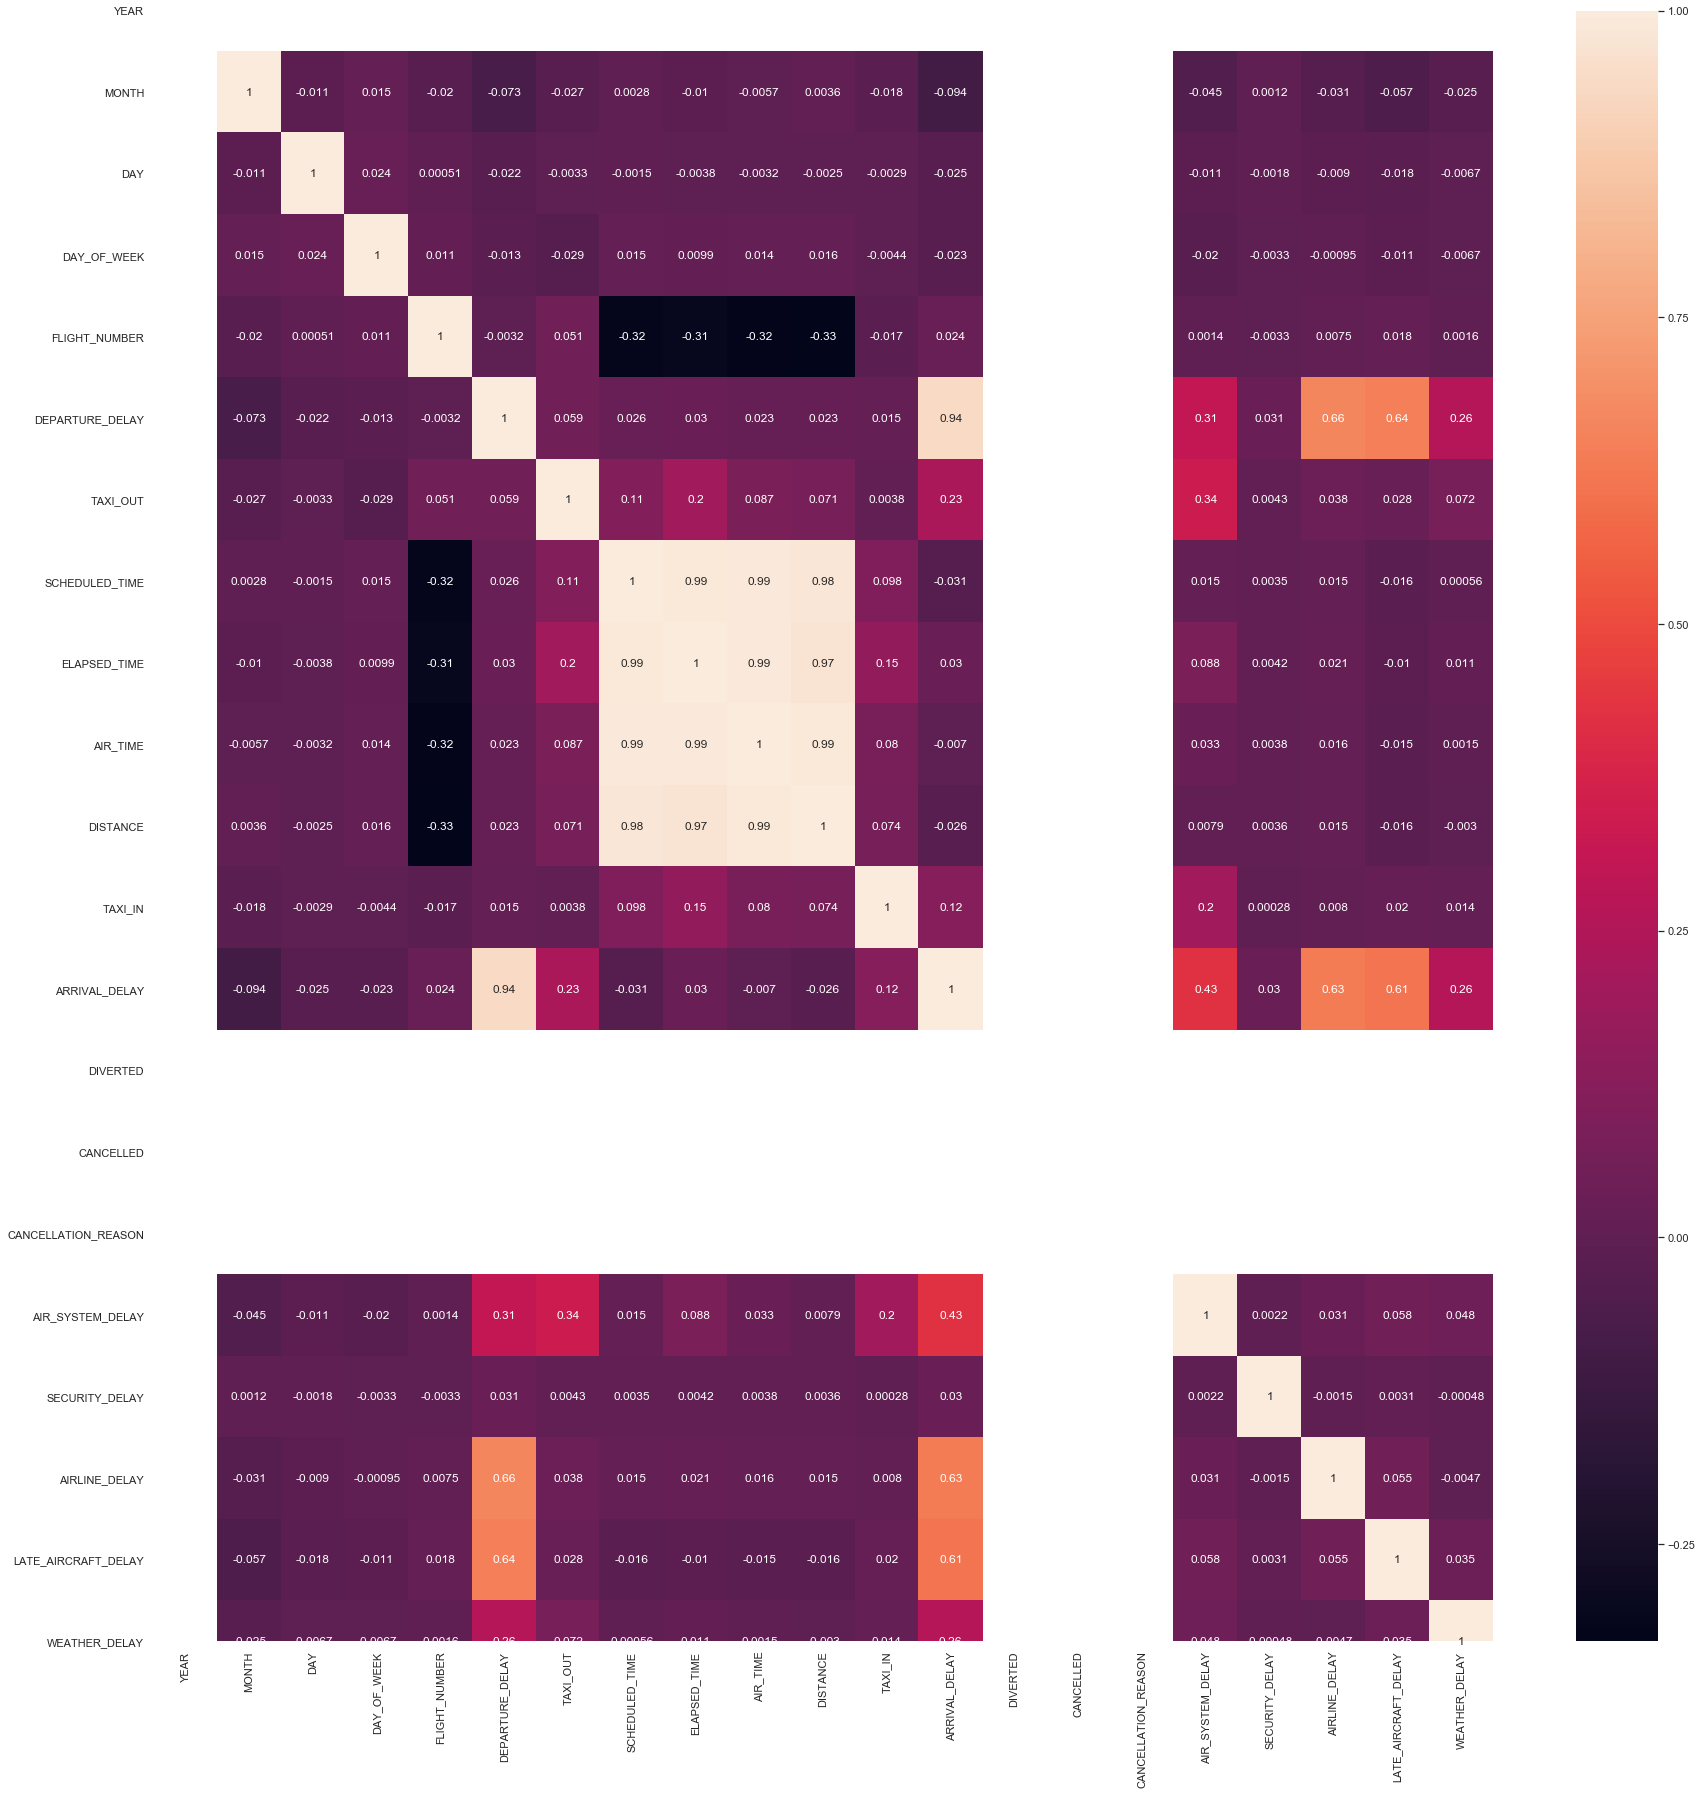

In [36]:
del_corr =flights.corr()
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(del_corr,annot=True)
plt.show()

Mocne korelacje (powyżej 0.60) pomędzy cehcami:

DEPARTURE_DELAY i ARRIVAL_DELAY, LATE_AIRCRAFT_DELAY, AIRLINE_DELAY

Średne korelacje ( do 0.60 od 0.2) pomędzy cehcami:

ARRIVAL_DELAY i AIR_SYSTEM_DELAY, WEATHER_DELAY

DEPARTURE_DELAY i AIR_SYSTEM_DELAY, WEATHER_DELAY

TAXI_OUT i AIR_SYSTEM_DELAY, ELAPSED_TIME

Poniższy wykres prezentuje liczbę opóźnionych lotów danych linii lotniczych.

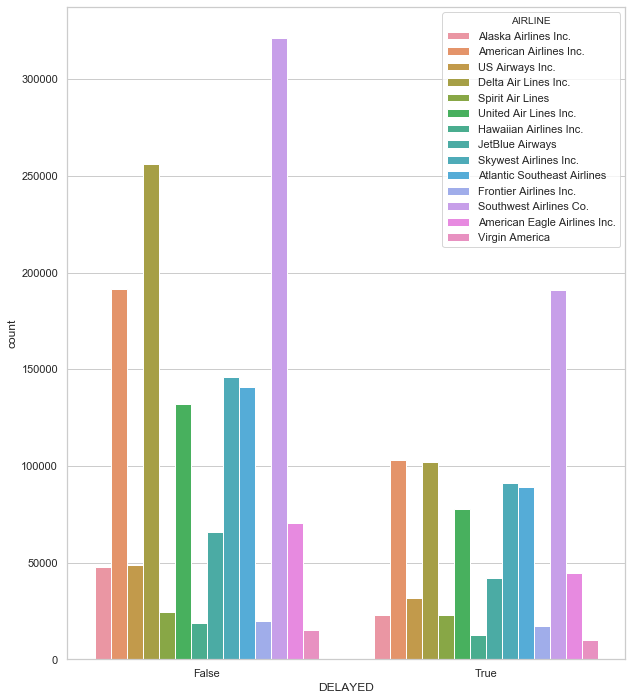

In [40]:
flights['DELAYED'] = flights.loc[:,'ARRIVAL_DELAY'].values > 0
figsize=plt.subplots(figsize=(10,12))
sns.countplot(x='DELAYED',hue='AIRLINE',data=flights)
plt.show()